# Requirements and Setup

In order to execute this notebook, make sure you have already installed the necessary requirements described in the README.md.
The following are all the necessary imports to run the entire notebook, from start to end.

In [1]:
import os 
import glob
import pandas as pd 
import numpy as np
from main.tree.linkageTree import linkageCut
from main.tsp.TSP_Formulation_Methods import ( 
    create_QUBO_matrix,
    solve_qubo_with_Dwave,
    check_solution,
    check_solution_return,
    compute_general_lambdas,
    load_lambda_means,
    brute_force_finding,
    calculate_distances_cost_of_bidireccional_routes,
)
from main.vqaa.vqaa_tools import ( 
    heuristical_embedding, 
    atoms_register,
    atoms_list, 
    generate_grid,
    run_vqaa,
    plot_distribution,
)
from main.tree.utils import ( 
    view_linkage_on_map, 
    draw_centers_on_map,
    map_draw_line,
    convert_bitstring_to_matrix,
    assemble_line,
    string_to_bitstring,
)
from main.pipe import give_line
from data.utils import fetch_amenities_from

# Load initial data 

This notebooks shows the proof-of-concept of the bus line optimization algorithm developed. To start, we must first fetch data from a specific city.
In this case, we fetch the data from Granada, Spain. The data consists of local amenities. We call our hierarchical clustering algorithm (ward distance) to propose a city multi-level view. In this proof of concept we will work with 2 levels, that means that the level 0
will create nclusters (red) and level 1 will further divide each cluster in nclusters (blue).

In [2]:
# Load previously stored overpy lat/lon datafile for different amenities
filepath = os.path.join('data', 'amenities-granada.csv')
if os.path.exists(filepath):
    amenities_data = pd.read_csv(filepath)
else:
    # If there is no previous data:
    query_file = os.path.join('data', 'overpy-granada-query.txt')
    query = None
    with open(query_file) as file:
        query = file.read()
    amenities_data = fetch_amenities_from(query=query) # Defaults to Granada
    amenities_data.to_csv(filepath)
    
# Create a hierarchical clustering of amenities
hierarchical_cluster = linkageCut(amenities_data)
# Set a specific number of clusters per levels. Max 9 in this POC
nclusters = 4
levels = 2
labels = hierarchical_cluster.top_down_view_recur(nclusters=nclusters, levels=2)
# Visualize for debugging purposes.
view_linkage_on_map(linkage_matrix=hierarchical_cluster)

# Level 0 solutions

We call Level 0 solutions to the larger regions( i.e., clusters) defined by the clustering. These will define the general flow of the bus 
route, dictating how we will connect the real bus stops once we solve the 'zoomed-in' problem.
We show the division proposed by the hierarchical algorithm, which for the city of Granada is in fact close to a district level organization. 

In [3]:
# Fetch the centers of the first level
centers = hierarchical_cluster.give_centers_level(0)
# Sanity check by drawing the graph
draw_centers_on_map(centers, color='red')

For our example we will impose two random nodes as start and endpoints. This works as a typical use-case: say we wanted to connect a marginalized area with another area where public services or/and green spaces are available. These extreme nodes will work as the extremes of the route. Additionally, we will fix for the route to traverse a fixed (p) number of districts (level-0 clusters).

In [4]:
np.random.seed(42)
# Fetch the distance from the centers of the first level
distances = hierarchical_cluster.dist_matrix_level(0, return_labels=False)
# Set initial global parameters
N = distances.shape[0]
p = 1
node_options = set(np.arange(nclusters) + 1)
startNode_0 = np.random.choice(list(node_options))
endNode_0 = np.random.choice(list(node_options - set([startNode_0])))
print("Selected random nodes:", startNode_0, endNode_0)

# Process Parameters
p = min(p, N-1)
startNode_0 = min(startNode_0, N)
endNode_0 = min(endNode_0, N)

reduced_distances = distances/np.max(distances)
maxDistance = np.max(reduced_distances)
# lambdas = compute_general_lambdas(reduced_distances, max_N = 3)
lambda_paths = glob.glob(os.path.join('data', 'lamdasOptimized', '*'))
lambdas = load_lambda_means(lambda_paths)

Selected random nodes: 3 1


The general procedure is shown here. First, the QUBO matrix is generated, with constraints penalties optimized for the problem (see docs).
Second, we embed the atoms and then we use any of the available emulators to solve the QUBO problem. In this case, we compare the solution with the brute force result. The brute fore solution will only be computed when $N\cdot p < 15$, since we have to check $2^{N\cdot p}$ combinations. Then, we can plot the raw result: the number of counts.

WARNING: The simulator may explode sometimes giving 0000.. as only counts or DMM/wavelength error 

Our solution reference is:
00101000


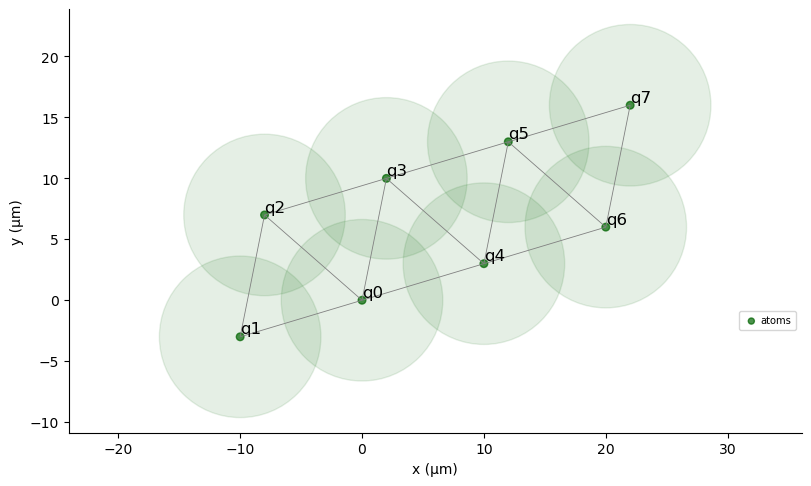

Variational in progress [1.8343479 7.79691  ]
Variational in progress [2.8343479 7.79691  ]
Variational in progress [1.8343479 8.79691  ]
Variational in progress [1.         7.24567177]
Variational in progress [1.         6.24567177]


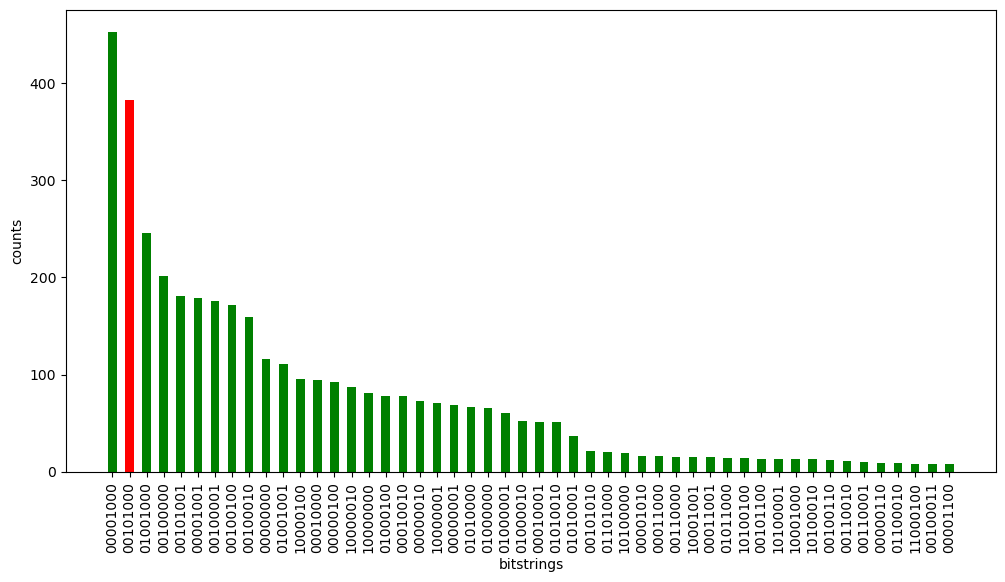

In [5]:
Q_matrix_initial,_ = create_QUBO_matrix(reduced_distances, p, startNode_0 - 1, endNode_0 - 1, lambdas)   

if N*(p+1) < 20:
    # Getting first solution, the one with lower cost
    solution_ref = brute_force_finding(Q_matrix_initial, reduced_distances, p, False)[0][0]
else:
    solution_ref, _ = solve_qubo_with_Dwave(Q_matrix_initial, num_reads=1000)
    
print('Our solution reference is:')
print(solution_ref)
check_solution(string_to_bitstring(solution_ref), N,  p, startNode_0 - 1, endNode_0 - 1)

# Creating register and solving VQAA
coords = heuristical_embedding(atoms_list(len(Q_matrix_initial)), generate_grid(50, 50,1), Q_matrix_initial)
register = atoms_register(coords)
# Emulator options: "qutip" (pulser), "mps", and "sv"
emulator = 'sv'
C_0, x = run_vqaa(Q_matrix_initial, register, emulator)

plot_distribution(C_0, 50, "".join([str(x) for x in solution_ref]))

Now that we have the set of proposed solutions, the ones with higher counts (in this case we select about 300) we can  verify our imposed QUBO constraints. Furthermore, from our surviving options, we can select the 
one with lower associated cost in terms of distance: our main objective! We explicitely define the function to highlight its simplicity.

In [6]:
def get_best_solution(proposed_sols, distances, s_node, e_node, p):
    # Discard solutions that do not fulfill our constraints
    constrained = [check_solution_return(string_to_bitstring(sol), N, p, s_node - 1, e_node - 1) for sol in proposed_sols]
    # Select the one(s) with lower distance associated cost
    distance_costs = np.array([calculate_distances_cost_of_bidireccional_routes(np.array(string_to_bitstring(sol)), distances, p) for sol in proposed_sols])
    if np.sum(constrained) == 0:
        raise ValueError('No valid solution, consider increasing the number of proposed solutions or VQAA didnt do its job')
    return proposed_sols[constrained][np.argmin(distance_costs[constrained])]

nchecks = 1024
number_props = min(int(len(C_0.keys())), nchecks)
print('We are checking the constraints for these number of solutions:')
print(number_props)
print('To compare with all possible solutions:', 2**(N*(p+1)))
C_ = dict(sorted(C_0.items(), key=lambda item: item[1], reverse=True))
proposed_sols = np.array(list(C_.keys() ) )[:number_props]
level0_sols = get_best_solution(proposed_sols, distances, startNode_0, endNode_0, p) # symmetric matrix means that we are counting distances twice
level0_sols = np.array(string_to_bitstring(level0_sols))
print("Found solution:", level0_sols)

We are checking the constraints for these number of solutions:
85
To compare with all possible solutions: 256
Found solution: [0 0 1 0 1 0 0 0]


In [7]:
adjacency = convert_bitstring_to_matrix(level0_sols, N=N, p=p)
map_draw_line(centers[:, ::-1], adjacency, color='red')

# Level 1 solutions

In [8]:
# Formulation with initial lambdas
level1_sols = {} # Dict that will hold the bitstring, connected level-0 clusters and corresponding start-end nodes 
nchecks = 1024
all_indices = set(np.arange(nclusters - 1) + 1)
for i in range(1, nclusters+1):
    
    connections = np.concatenate([adjacency[:,i-1].nonzero()[0], adjacency[i-1, :].nonzero()[0]], axis=0) + 1
    print("----- Solving level-1:", i, "------\n")
    print("connections", connections)
    if len(connections) > 0: #Selected
        # Fetch the centers of the first level
        distances, closest, _ = hierarchical_cluster.dist_matrix_label_down(
        i,
        connections=connections,
        )
        
        startNode_ = None
        if len(closest) >= 1:
            startNode_ = closest[0]
            choices = all_indices - set([startNode_])
        if len(closest) == 2:
            endNode_ = closest[1]
        else:
            endNode_ = np.random.choice(list(choices)) # POC criterion, better heuristic should be chosen
        print("Start-end", startNode_, endNode_)
        reduced_distances = distances / np.max(distances)
        Q_matrix_initial,_ = create_QUBO_matrix(reduced_distances, p, startNode_ - 1, endNode_ - 1, lambdas)
        
        # Creating register and solving VQAA
        coords = heuristical_embedding(atoms_list(len(Q_matrix_initial)), generate_grid(50, 50,1), Q_matrix_initial)
        register = atoms_register(coords, show=False)
        C_1, x = run_vqaa(Q_matrix_initial, register, emulator)
        
        # Our ref is Dwave
        solution_ref = solve_qubo_with_Dwave(Q_matrix_initial, num_reads=1000)
        #plot_distribution(C_1, 50, "".join([str(x) for x in solution_ref]))
        
        C_ = dict(sorted(C_1.items(), key=lambda item: item[1], reverse=True))
        number_props = min(int(len(C_1.keys())), nchecks)

        proposed_sols = np.array(list(C_.keys() ) )[:number_props]
        sol_ =  get_best_solution(proposed_sols, distances, startNode_, endNode_, p) # symmetric matrix means that we are counting distances twice
        print("Proposed solution bitstring:")
        print(sol_)
        sol_ = string_to_bitstring(sol_)
        level1_sols[i] = [sol_, closest]
        
    else:
        level1_sols[i] = (np.zeros((nclusters*(p + 1))), [])
        print('The line does not cross this level-0 cluster')


----- Solving level-1: 1 ------

connections [3]
Start-end 4 1
Variational in progress [1.5601864 1.5599452]
Variational in progress [2.5601864 1.5599452]
Variational in progress [1.5601864 2.5599452]
Variational in progress [1.02858886 3.40694228]
Variational in progress [1.         4.40653353]
Proposed solution bitstring:
00011000
----- Solving level-1: 2 ------

connections []
The line does not cross this level-0 cluster
----- Solving level-1: 3 ------

connections [1]
Start-end 4 3
Variational in progress [8.66176146 6.01115012]
Variational in progress [9.66176146 6.01115012]
Variational in progress [8.66176146 7.01115012]
Variational in progress [7.73333229 5.63964067]
Variational in progress [8.19754687 5.82539539]
Proposed solution bitstring:
00010010
----- Solving level-1: 4 ------

connections []
The line does not cross this level-0 cluster


This is how one route at level 1 looks like. Feel free to try different example_indx. The clusters where the line is defined are:
In red the computed level-0 line, in blue the example_indx 'zoomed-in' solution for the zone

In [10]:
print(np.nonzero(level0_sols.reshape(p+1, N))[1] + 1)

[3 1]


In [11]:
example_indx = 3
example_centers = hierarchical_cluster.give_centers_label_down(example_indx)
example_adj = convert_bitstring_to_matrix(level1_sols[example_indx][0],N=nclusters, p=p)
map = map_draw_line(centers[:, ::-1], adjacency, color='red')
map_draw_line(example_centers[:, ::-1], example_adj, color='blue', map=map)

Let's piece all the information about the calculated lines at level 1 together using what we know about the connections at level 0. Effectively creating a unified route.

How do we join all these disconnected level-1 mini-routes? The larger-scale route is given by the level 0. We know that 1 should be connected with 2, then we can connect the closest (driving distance) clusters.

In [12]:
assembled = assemble_line(level0_sols,level1_sols, nclusters, p)

[3 1]


In [13]:
centers_level1 = hierarchical_cluster.give_centers_level(1)
map = map_draw_line(centers_level1[:,::-1], assembled, color='blue', zoom_start=14)
map

## Adding another line

How can we now create another bus route? We follow the same procedure, but we consider some information about pre-existing bus routes. For the scope of this proof of concept,  in which the number of clusters is low, we will force the solution to pass through other level-0 zones by selecting different start and endNodes. In a real case scenario, some heuristic can be adopoted, e.g., spatial coverage. For this, we call a pre-defined class that implements the steps previously presened.

In [14]:
new_nodes = set(np.arange(nclusters) + 1) - set([startNode_0])
new_startNode_0 = np.random.choice(list(new_nodes))
new_endNode_0 = np.random.choice(list(new_nodes - set([new_startNode_0])))
new_line = give_line(amenities_data, nclusters, p, new_startNode_0, new_endNode_0,'sv')

----- Solving level 0 ------

Variational in progress [0.48724881 2.8910966 ]
Variational in progress [1.48724881 2.8910966 ]
Variational in progress [0.48724881 3.8910966 ]
Variational in progress [1.         2.03255934]
Variational in progress [1.         1.03255934]
----- Solving level-1: 1 ------

----- Solving level-1: 2 ------

----- Solving level 2 ------

Variational in progress [0.36147677 9.51598981]
Variational in progress [1.36147677 9.51598981]
Variational in progress [ 1.36147677 10.51598981]
Variational in progress [2.35703215 9.42181189]
Variational in progress [1.85925446 9.46890085]
----- Solving level-1: 3 ------

----- Solving level-1: 4 ------

----- Solving level 4 ------

Variational in progress [0.50773257 3.02271894]
Variational in progress [1.50773257 3.02271894]
Variational in progress [1.50773257 4.02271894]
Variational in progress [2.08622504 2.20703121]
Variational in progress [1.7969788  2.61487508]


In [15]:
new_assembled = assemble_line(new_line[0], new_line[1], nclusters, p)
centers_level1 = hierarchical_cluster.give_centers_level(1)

map = map_draw_line(centers_level1[:,::-1], assembled, color='blue', zoom_start=14, map=map)
map = map_draw_line(centers_level1[:,::-1], new_assembled, color='green', zoom_start=14, map=map)
map

[4 2]


# Save a picture

In case you liked the solution and want to propose it to your city mayor, run the following cell to save the last drawn example!
Be quick, major changes must be made to optimize the public transport and they run slow.

In [ ]:
# import io
# from PIL import Image
# Requires selenium, in case you don't have it, uncomment the following line
# !pip install selenium
# img_data = map._to_png(5)
# img = Image.open(io.BytesIO(img_data))
# img.save('imgs/example.png')